In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로딩

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 전처리

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# numpy → tensor 변환 후 GPU로 이동
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [6]:
# train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# DataLoader에서는 CPU 텐서를 사용하고, batch에서 GPU로 이동


In [7]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

In [8]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# 모델 생성

In [9]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)   # 입력: 4차원 feature
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)    # 출력: 3 클래스
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
model = DNN().to(device)  # 모델 GPU 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습

In [11]:
train_losses, val_losses, val_accuracies = [], [], []

In [12]:
for epoch in range(50):
    model.train()
    running_loss = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 배치 데이터 GPU 이동
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # ----- Validation -----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 배치 데이터 GPU 이동
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/50], Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch [1/50], Train Loss: 1.0542, Val Loss: 0.9660, Val Acc: 63.33%
Epoch [2/50], Train Loss: 0.8632, Val Loss: 0.6996, Val Acc: 73.33%
Epoch [3/50], Train Loss: 0.6274, Val Loss: 0.4730, Val Acc: 70.00%
Epoch [4/50], Train Loss: 0.4573, Val Loss: 0.3819, Val Acc: 73.33%
Epoch [5/50], Train Loss: 0.3898, Val Loss: 0.3317, Val Acc: 83.33%
Epoch [6/50], Train Loss: 0.3510, Val Loss: 0.2803, Val Acc: 86.67%
Epoch [7/50], Train Loss: 0.3001, Val Loss: 0.2253, Val Acc: 93.33%
Epoch [8/50], Train Loss: 0.2667, Val Loss: 0.1759, Val Acc: 93.33%
Epoch [9/50], Train Loss: 0.2218, Val Loss: 0.1371, Val Acc: 100.00%
Epoch [10/50], Train Loss: 0.1688, Val Loss: 0.1174, Val Acc: 96.67%
Epoch [11/50], Train Loss: 0.1312, Val Loss: 0.0821, Val Acc: 100.00%
Epoch [12/50], Train Loss: 0.1135, Val Loss: 0.0694, Val Acc: 100.00%
Epoch [13/50], Train Loss: 0.0921, Val Loss: 0.0704, Val Acc: 96.67%
Epoch [14/50], Train Loss: 0.0931, Val Loss: 0.0707, Val Acc: 96.67%
Epoch [15/50], Train Loss: 0.0783, Val L

# 학습결과 확인

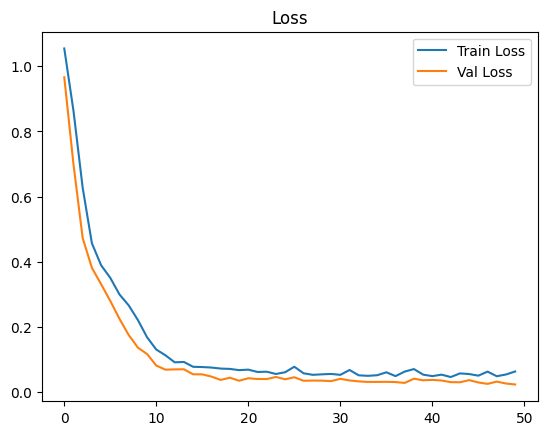

In [13]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

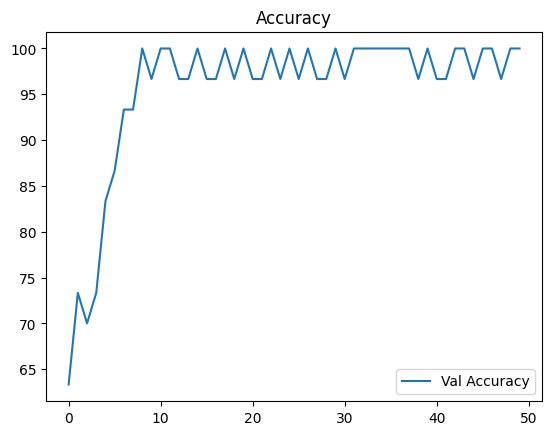

In [14]:
plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()